In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
%matplotlib notebook

In [191]:
# from jax.config import config
# We need 64 bit floats so that solving for Te (Egedal et al) remains stable for a wide range
# config.update("jax_enable_x64", True)

# ## Values / JAX variables to optimize for
values = {
    'Eb': 1000.,
    'beta': 0.8,
    'B_pm': 30.,
    'B_p': 6.,
    'r_b': 0.25,
    'L_p': 4.,
    'p_aux': 0.0,  # this is in addition to synchotrfrom tqdm.notebook import tqdmon losses (which are calculated separately)
    'T_frac': 0.5,
    'Tep_fudge': 0.5,  # this should remain constant

    'B_cc': 1.5,
    'n_ccr': 0.25,
    'Ti_ccr': 1.0,
    'Te_ccr': 1.0,
    'L_cc': 20.0,

    # efficiencies should remain constant
    'Ef_DEC': 0.7,
    'Ef_TE': 0.5,
    'Ef_ECH': 0.6,
    'Ef_NBI': 0.6,
    'Ef_RF': 0.9,

    # engineering parameters remaining constant (for now)
    'd_blanket': 0.6,
    'd_vv': 0.2,
    'a_wall_r': 1.1,
    'cost_HTS_kAm': 1e-4,  # in megadollars (M$)
    'coil_spacing_cc': 1.0,  # in meters

    # physical quantities that are remaining constant for simplicity
    'mu': 2.5,
    'Z_eff': 1.13,
    'I_cooling': 0.0
}

# ## Flags
flags = {
    # assumes Ti_plug = 2/3 E_inj and Te_plug = 0.09 log(Rm/(sqrt(1-beta))^0.4)
    'simple_temps': False,
    'DD_cat': False,  # assumes DD fusion products are burned instantly. Is there any reason to turn this off?
    'field_reg_alphas': False,  # Regularize midplane field strengths via an alpha particle gyroradii heuristic
    'field_reg_Bohm': False,  # Regularize midplane field via Bohm diffusion heuristic
    'cc_aux_ECH': True,  # Use ECH to replace tandem mirror axial losses
}

# Need to do this horrible, horrible thing so that all the variables are in the same namespace.
# I could class-ify everything but that would require adding "self" or "global" into a bunch of
#   variables which would be super cluttered.
exec(open('mirror_physics_setup-gyroBohm.py').read())
exec(open('optimization_setup.py').read())
from tqdm.notebook import tqdm

In [192]:
values_to_opt = values.copy()
num_values = 8

values_to_opt['beta'] = jnp.ones(num_values) * values_to_opt['beta']
values_to_opt['Tep_fudge'] = jnp.ones(num_values) * values_to_opt['Tep_fudge']
values_to_opt['p_aux'] = jnp.zeros(num_values)

values_to_opt['Ti_ccr'] = jnp.ones(num_values) * values_to_opt['Ti_ccr']
values_to_opt['Te_ccr'] = jnp.ones(num_values) * values_to_opt['Te_ccr']
values_to_opt['Ef_DEC'] = jnp.ones(num_values) * values_to_opt['Ef_DEC']
values_to_opt['Ef_TE'] = jnp.ones(num_values) * values_to_opt['Ef_TE']
values_to_opt['Ef_ECH'] = jnp.ones(num_values) * values_to_opt['Ef_ECH']
values_to_opt['Ef_NBI'] = jnp.ones(num_values) * values_to_opt['Ef_NBI']
values_to_opt['Ef_RF'] = jnp.ones(num_values) * values_to_opt['Ef_RF']
values_to_opt['d_blanket'] = jnp.ones(num_values) * values_to_opt['d_blanket']
values_to_opt['d_vv'] = jnp.ones(num_values) * values_to_opt['d_vv']
values_to_opt['a_wall_r'] = jnp.ones(num_values) * values_to_opt['a_wall_r']
values_to_opt['cost_HTS_kAm'] = jnp.ones(num_values) * values_to_opt['cost_HTS_kAm']
values_to_opt['coil_spacing_cc'] = jnp.ones(num_values) * values_to_opt['coil_spacing_cc']

values_to_opt['mu'] = jnp.ones(num_values) * values_to_opt['mu']
values_to_opt['Z_eff'] = jnp.ones(num_values) * values_to_opt['Z_eff']

key = jax.random.PRNGKey(0)
values_to_opt['Eb'] = jax.random.uniform(key, shape=(num_values,)) * 500. + 100.
values_to_opt['B_pm'] = jax.random.uniform(key, shape=(num_values,)) * 14. + 6.
values_to_opt['B_p'] = jax.random.uniform(key, shape=(num_values,)) * 5.4 + 0.5
values_to_opt['r_b'] = jax.random.uniform(key, shape=(num_values,)) * 0.4 + 0.1
values_to_opt['L_p'] = jax.random.uniform(key, shape=(num_values,)) * 9. + 1.
values_to_opt['T_frac'] = jnp.ones(num_values) * 0.5
values_to_opt['B_cc'] = jax.random.uniform(key, shape=(num_values,)) * 5.4 + 0.5
values_to_opt['n_ccr'] = jax.random.uniform(key, shape=(num_values,)) * 0.95 + 0.05
values_to_opt['L_cc'] = jax.random.uniform(key, shape=(num_values,)) * 45. + 5.

In [16]:
tandem_net_cost.free_symbols

{B_cc,
 B_p,
 B_pm,
 DD_reac,
 DT_reac,
 Eb,
 Ef_DEC,
 Ef_ECH,
 Ef_NBI,
 Ef_TE,
 L_cc,
 L_p,
 T_frac,
 Te,
 Te_ccr,
 Ti,
 Ti_ccr,
 Z_eff,
 a_wall_r,
 beta,
 coil_spacing_cc,
 cost_HTS_kAm,
 d_blanket,
 d_vv,
 mu,
 n_ccr,
 r_b}

In [375]:
# Optimize with respect to the following:
# opt_symbol_list = [B_pm, B_p, r_b, L_p, T_frac, Eb]
opt_symbol_list = [Eb, B_pm, B_p, r_b, L_p, T_frac, B_cc, n_ccr, L_cc]
tandem_net_cost = sympy.Abs(((cost_B_cc  + cost_B_p  + cost_B_pm  + cost_heat_total)) / ((P_recirculating + P_thermal_electric - P_electric_in) * 30 * 8760))
# tandem_net_cost = ((cost_B_cc * 1e6 + cost_B_p * 1e6 + cost_B_pm * 1e6 + cost_heat_total)) / ((P_recirculating + P_thermal_electric) * 30 * 8760)
# tandem_net_cost = -1.0 * Q_tandem

# 30 years, $30 / MWh
# tandem_net_cost = ((cost_B_cc * 1e6 + cost_B_p * 1e6 + cost_B_pm * 1e6 + cost_heat_total)) - ((P_recirculating + P_thermal_electric - P_electric_in) * 30 * 8760 * 30)

tandem_opt = Optimizer(tandem_net_cost, opt_symbol_list, values_to_opt, flags)

Compiling JAX functions...


In [370]:
tandem_opt.reset_runs()

In [371]:
tandem_opt.run(num_iterations=1000, momentum=False, step_size=1e-16);

  0%|          | 0/1000 [00:00<?, ?it/s]

In [368]:
tandem_opt.evaluate(iter_start=0)

Array([1.79059887e+10, 8.71136393e+12, 3.84974271e+10, 8.54928087e+11,
       4.47523789e+10, 2.12893683e+09, 1.55339179e+11, 6.60057394e+11],      dtype=float64)

<IPython.core.display.Javascript object>


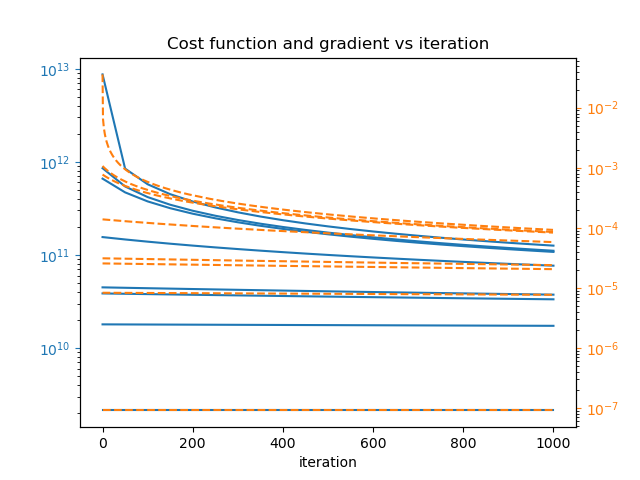

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Cost function and gradient vs iteration')

In [373]:
# print(jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 0])

fig, axQ = plt.subplots()
axQ.set_yscale('log')
axQ.plot(np.arange(0, 1001, 50), jnp.array(tandem_opt.evaluate(0, 1001, 50))[:, :], color="#1f77b4")
# axQ.plot(np.arange(0, 1001, 50), jnp.array(tandem_opt.evaluate(0, 1001, 50))[:, 0], label='Cost', color="#1f77b4")
axQ.tick_params(colors="#1f77b4", axis='y')
axGrad = axQ.twinx()
axGrad.plot(np.arange(0, 1000), np.sqrt(np.sum((np.array(tandem_opt.loop_gradients) * tandem_opt.opt_idx_mask) ** 2, axis=1))[:, :],
            color='#ff7f0e', linestyle='--')
# axGrad.plot(np.arange(0, 1000), np.sqrt(np.sum((np.array(tandem_opt.loop_gradients) * simple_Q_opt.opt_idx_mask) ** 2, axis=1))[:, 0],
#             color='#ff7f0e', label='grad l2 norm')
axGrad.tick_params(colors="#ff7f0e", axis='y')
axGrad.set_yscale('log')
axQ.set_xlabel('iteration')
# fig.legend()
axQ.set_title('Cost function and gradient vs iteration')
# axGrad.legend()
# plt.savefig('tandem_cost.pdf')

In [374]:
idx_to_print = 0
final_time = -1
print("symbol \t value_i \t value_f \t RMS grad")
for i in range(len(tandem_opt.symbol_list)):
    print(tandem_opt.symbol_list[i].name + ":\t {:.4e}".format(tandem_opt.loop_values[0][i, idx_to_print]) + ":\t {:.4e}".format(
        tandem_opt.loop_values[final_time][i, idx_to_print]), "\t {:.4e}".format(np.sqrt(np.sum(np.array(tandem_opt.loop_gradients[0:final_time]) ** 2, axis=0))[i, idx_to_print]))

symbol 	 value_i 	 value_f 	 RMS grad
coil_spacing_cc:	 1.0000e+00:	 1.0000e+00 	 0.0000e+00
Ti_ccr:	 1.0000e+00:	 1.0000e+00 	 0.0000e+00
Z_eff:	 1.1300e+00:	 1.1300e+00 	 0.0000e+00
cost_HTS_kAm:	 1.0000e-04:	 1.0000e-04 	 0.0000e+00
a_wall_r:	 1.1000e+00:	 1.1000e+00 	 0.0000e+00
B_p:	 3.3825e+00:	 3.3817e+00 	 2.5058e-05
L_cc:	 2.9021e+01:	 2.9021e+01 	 9.1250e-07
Ef_NBI:	 6.0000e-01:	 6.0000e-01 	 0.0000e+00
Ef_DEC:	 7.0000e-01:	 7.0000e-01 	 0.0000e+00
T_frac:	 5.0000e-01:	 5.0000e-01 	 3.9857e-08
L_p:	 5.8042e+00:	 5.8040e+00 	 4.9876e-06
Ef_TE:	 5.0000e-01:	 5.0000e-01 	 0.0000e+00
Te_ccr:	 1.0000e+00:	 1.0000e+00 	 0.0000e+00
p_aux:	 0.0000e+00:	 0.0000e+00 	 0.0000e+00
Ef_ECH:	 6.0000e-01:	 6.0000e-01 	 0.0000e+00
r_b:	 3.1352e-01:	 3.0915e-01 	 1.3816e-04
Tep_fudge:	 5.0000e-01:	 5.0000e-01 	 0.0000e+00
d_blanket:	 6.0000e-01:	 6.0000e-01 	 0.0000e+00
Eb:	 3.6690e+02:	 3.6690e+02 	 8.4406e-09
B_cc:	 3.3825e+00:	 3.3827e+00 	 5.4234e-06
mu:	 2.5000e+00:	 2.5000e+00 	 0.0000e+

In [310]:
tandem_opt.evaluate(iter_start=5000)

Array([10.64856392, 42.69463005, 11.00809397, 15.87117723, 11.08791894,
               nan, 11.95717161, 14.67782551], dtype=float64)

In [316]:
tandem_opt.evaluate_sympy_func(Q_tandem, iter_start=5000)

Array([0.80041557, 0.67644361, 0.77185827, 0.56764995, 0.76609906,
              nan, 0.71225289, 0.5982894 ], dtype=float64)

In [314]:
tandem_opt.evaluate_sympy_func(P_recirculating + P_thermal_electric - P_electric_in, iter_start=5000)

ValueError: 'Ef_NBI' is not in list

In [313]:
tandem_opt.evaluate_sympy_func(P_recirculating + P_thermal_electric, iter_start=5000)

Array([ 3201.28738621, 39195.37006605,  3896.75025562,  4165.25026355,
        4015.10278251,            nan,  4722.81849289,  4416.49196897],      dtype=float64)

<IPython.core.display.Javascript object>


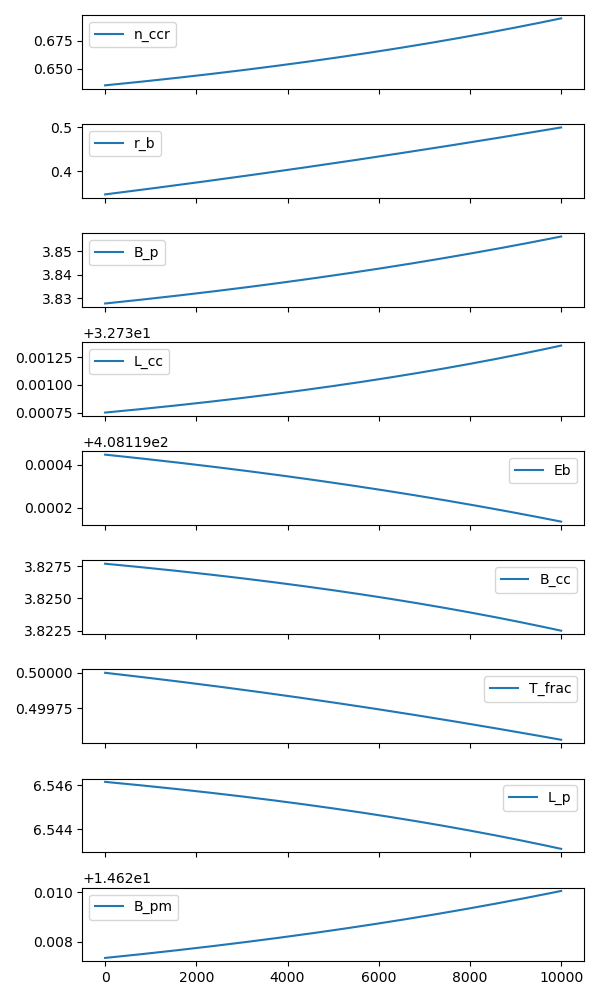

In [348]:
num_plot = len(tandem_opt.symbol_list)
fig, axes = plt.subplots(int(np.sum(tandem_opt.opt_idx_mask[:, 0]).astype(int)), figsize=(6, 10), sharex=True)
# print("symbol \t value_i \t value_f \t RMS grad")
j = 0
for i in range(num_plot):
#     print(tandem_symbol_list[i].name + ":\t {:.4e}".format(loop_values[0][i]) + ":\t {:.4e}".format(loop_values[-1][i]), "\t {:.4e}".format(np.sqrt(np.sum(np.array(loop_cost_grad[0:-1]) ** 2, axis=0))[i]))
    if tandem_opt.opt_idx_mask[i, 0] == 0:
        continue
    else:
        axes[j].plot(np.array(tandem_opt.loop_values)[:, i, 2], label=tandem_opt.symbol_list[i].name)
        axes[j].legend()
#         axes[j].set_title(tandem_symbol_list[i].name)
        j += 1
plt.legend()
plt.tight_layout()
# plt.savefig('good_tandem_params.pdf')

In [201]:
Q_optimized = simple_Q_opt.evaluate_sympy_func(Q_plug * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]